Consolidate the folds into a single set of results.

In particular, compute the mean and standard deviations of the models in the accuracy, recall and F-score. 

In [1]:
import numpy as np
import sys
import tensorflow as tf
from glob import glob
import os
sys.path.append('../../src')
sys.path.append('../../')


import classifier.Multiband as multiband
import base.plot as plot


In [2]:
# To reset cuda
# sudo rmmod nvidia_uvm
# sudo modprobe nvidia_uvm
# To see if the system regognises the GPU
device = 0
devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(devices[device], 'GPU')
tf.config.experimental.set_memory_growth(device=devices[device], enable=True)


2023-07-17 18:37:54.366852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 18:37:54.367029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 18:37:54.370660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 18:37:54.370831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-17 18:37:54.370970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Read the Results folder.

In [5]:
survey = 'Gaia'
path = os.path.join('../03_TrainModels/Results/Fold_*',)
folds = glob(path)
folds.sort()
folds

['../03_TrainModels/Results/Fold_1',
 '../03_TrainModels/Results/Fold_2',
 '../03_TrainModels/Results/Fold_3']

In [6]:
if not os.path.exists('./Results/'):
    os.mkdir('./Results/')

For each fold, read the models and evaluate on the test set. Save the results

In [7]:
label_order = ['CEP', 'T2CEP', 'MIRA_SR','RRAB', 'RRC', 'DSCT_SXPHE']

In [8]:
# Containers to store the results
reports_folds = []
cm_folds = []
regressions = []
for fold in folds:
    tf.keras.backend.clear_session()
    # Set the fold path
    base_dir = fold+'/'
    
    # Get the last run
    path_runs_folder = os.path.join(base_dir, 'Models', '*')
    path_runs = glob(path_runs_folder)
    path_runs.sort()
    path_run = path_runs[-1]    
    
    path_preprocess = fold.replace('/03_TrainModels/', '/02_CreateRecords/').replace('/Results/', '/Folds/')
    test_files = os.path.join(path_preprocess, 'test/*.tfrecord')
    path_preprocess = os.path.join(path_preprocess, 'metadata_preprocess.json')    

    
    new = multiband.Network()    
    settings_path = os.path.join(path_run, 'all_settings.json')

    fold_name = fold.split('/')[-1]
    write_path = os.path.join('./Results', fold_name+'_Results.dat')
    
    # If results already computed
    # if len(glob('./Results/*.dat'))!=7:
        
    # Get weights path
    run = path_run.split('/')[-1]
    weights_path = os.path.join(fold, 'Models', run)
    new.run_test(settings_path, test_files, weights_path, df_paths = write_path);
    
    result_path = os.path.join('./Results', fold.split('/')[-1]+'_Results.dat')
    
    # From the results file, read the data and compute the classification scores
    report_fold = plot.compute_classification_report(result_path)
    reports_folds.append(report_fold)
    # From the results file, read the data and compute the confussion matrix and the respective  labels 
    cm_fold = plot.compute_confussion_matrices(result_path, labels=label_order)
    cm_folds.append(cm_fold)
    # Extract the regression metrics
    regression = plot.compute_regression(result_path, new.physical_params)
    regressions.append(regression)

2023-07-07 20:03:16.235726: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-07 20:03:16.236151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 20:03:16.236371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-07 20:03:16.236516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

../02_CreateRecords/Folds/Fold_1/test/*.tfrecord


2023-07-07 20:03:26.415791: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


              precision    recall  f1-score   support

         CEP       0.52      0.91      0.66      1367
  DSCT_SXPHE       0.50      0.40      0.45       880
     MIRA_SR       0.87      0.91      0.89      2200
        RRAB       0.64      0.63      0.63      2200
         RRC       0.62      0.48      0.54      2200
       T2CEP       0.62      0.01      0.02       436

    accuracy                           0.65      9283
   macro avg       0.63      0.56      0.53      9283
weighted avg       0.66      0.65      0.63      9283

{'R2': {'T_eff': 0.8170352135638683, 'Radius': 0.6283922650155108}, 'RMSE': {'T_eff': 508.9868, 'Radius': 17.114172}}
../02_CreateRecords/Folds/Fold_2/test/*.tfrecord
              precision    recall  f1-score   support

         CEP       0.71      0.45      0.55      1367
  DSCT_SXPHE       0.60      0.20      0.29       880
     MIRA_SR       0.90      0.90      0.90      2200
        RRAB       0.54      0.79      0.64      2200
         RRC       

In [9]:

print('Median')
median, delta_pos, delta_neg = plot.obtain_accumulated_regressions(regressions, metric='median')
display(median, delta_pos, delta_neg)


Median


,R2,RMSE,MAPE
T_eff,0.803979,526.823508,0.070196
Radius,0.640792,16.033431,2.845417


,R2,RMSE,MAPE
T_eff,0.006528,31.378774,0.004567
Radius,0.001790,0.395839,0.069989


,R2,RMSE,MAPE
T_eff,0.024341,8.918370,0.002815
Radius,0.005773,0.054823,0.197372


In [10]:
median, delta_up, delta_down = plot.obtain_accumulated_metrics(reports_folds, metric='median', label_order=label_order)
display(median)
display(delta_up)
display(delta_down)

,CEP,T2CEP,MIRA_SR,RRAB,RRC,DSCT_SXPHE
precision,59.336735,35.185185,89.809783,63.648834,61.702128,56.655290
recall,85.076811,3.440367,90.545455,68.227273,58.681818,37.727273
f1-score,66.309588,5.928854,89.972777,63.905761,54.471129,44.528302
support,136700.000000,43600.000000,220000.000000,220000.000000,220000.000000,88000.000000


,CEP,T2CEP,MIRA_SR,RRAB,RRC,DSCT_SXPHE
precision,5.945668,13.657407,4.529754,6.368967,0.245786,1.637512
recall,2.743233,0.458716,4.409091,5.340909,5.590909,1.250000
f1-score,1.801623,0.913124,4.571535,4.085535,5.529304,0.382507
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,CEP,T2CEP,MIRA_SR,RRAB,RRC,DSCT_SXPHE
precision,3.517121,6.878307,1.543986,4.976288,6.455750,3.398068
recall,20.263350,1.146789,0.204545,2.477273,5.113636,9.090909
f1-score,5.747053,1.838301,0.690191,0.222769,0.595036,7.525505
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
(median/100).round(2)

,CEP,T2CEP,MIRA_SR,RRAB,RRC,DSCT_SXPHE
precision,0.59,0.35,0.90,0.64,0.62,0.57
recall,0.85,0.03,0.91,0.68,0.59,0.38
f1-score,0.66,0.06,0.90,0.64,0.54,0.45
support,1367.00,436.00,2200.00,2200.00,2200.00,880.00


In [12]:
np.round(median.loc['f1-score'].mean()/100,3)

0.542

<Figure size 640x480 with 0 Axes>

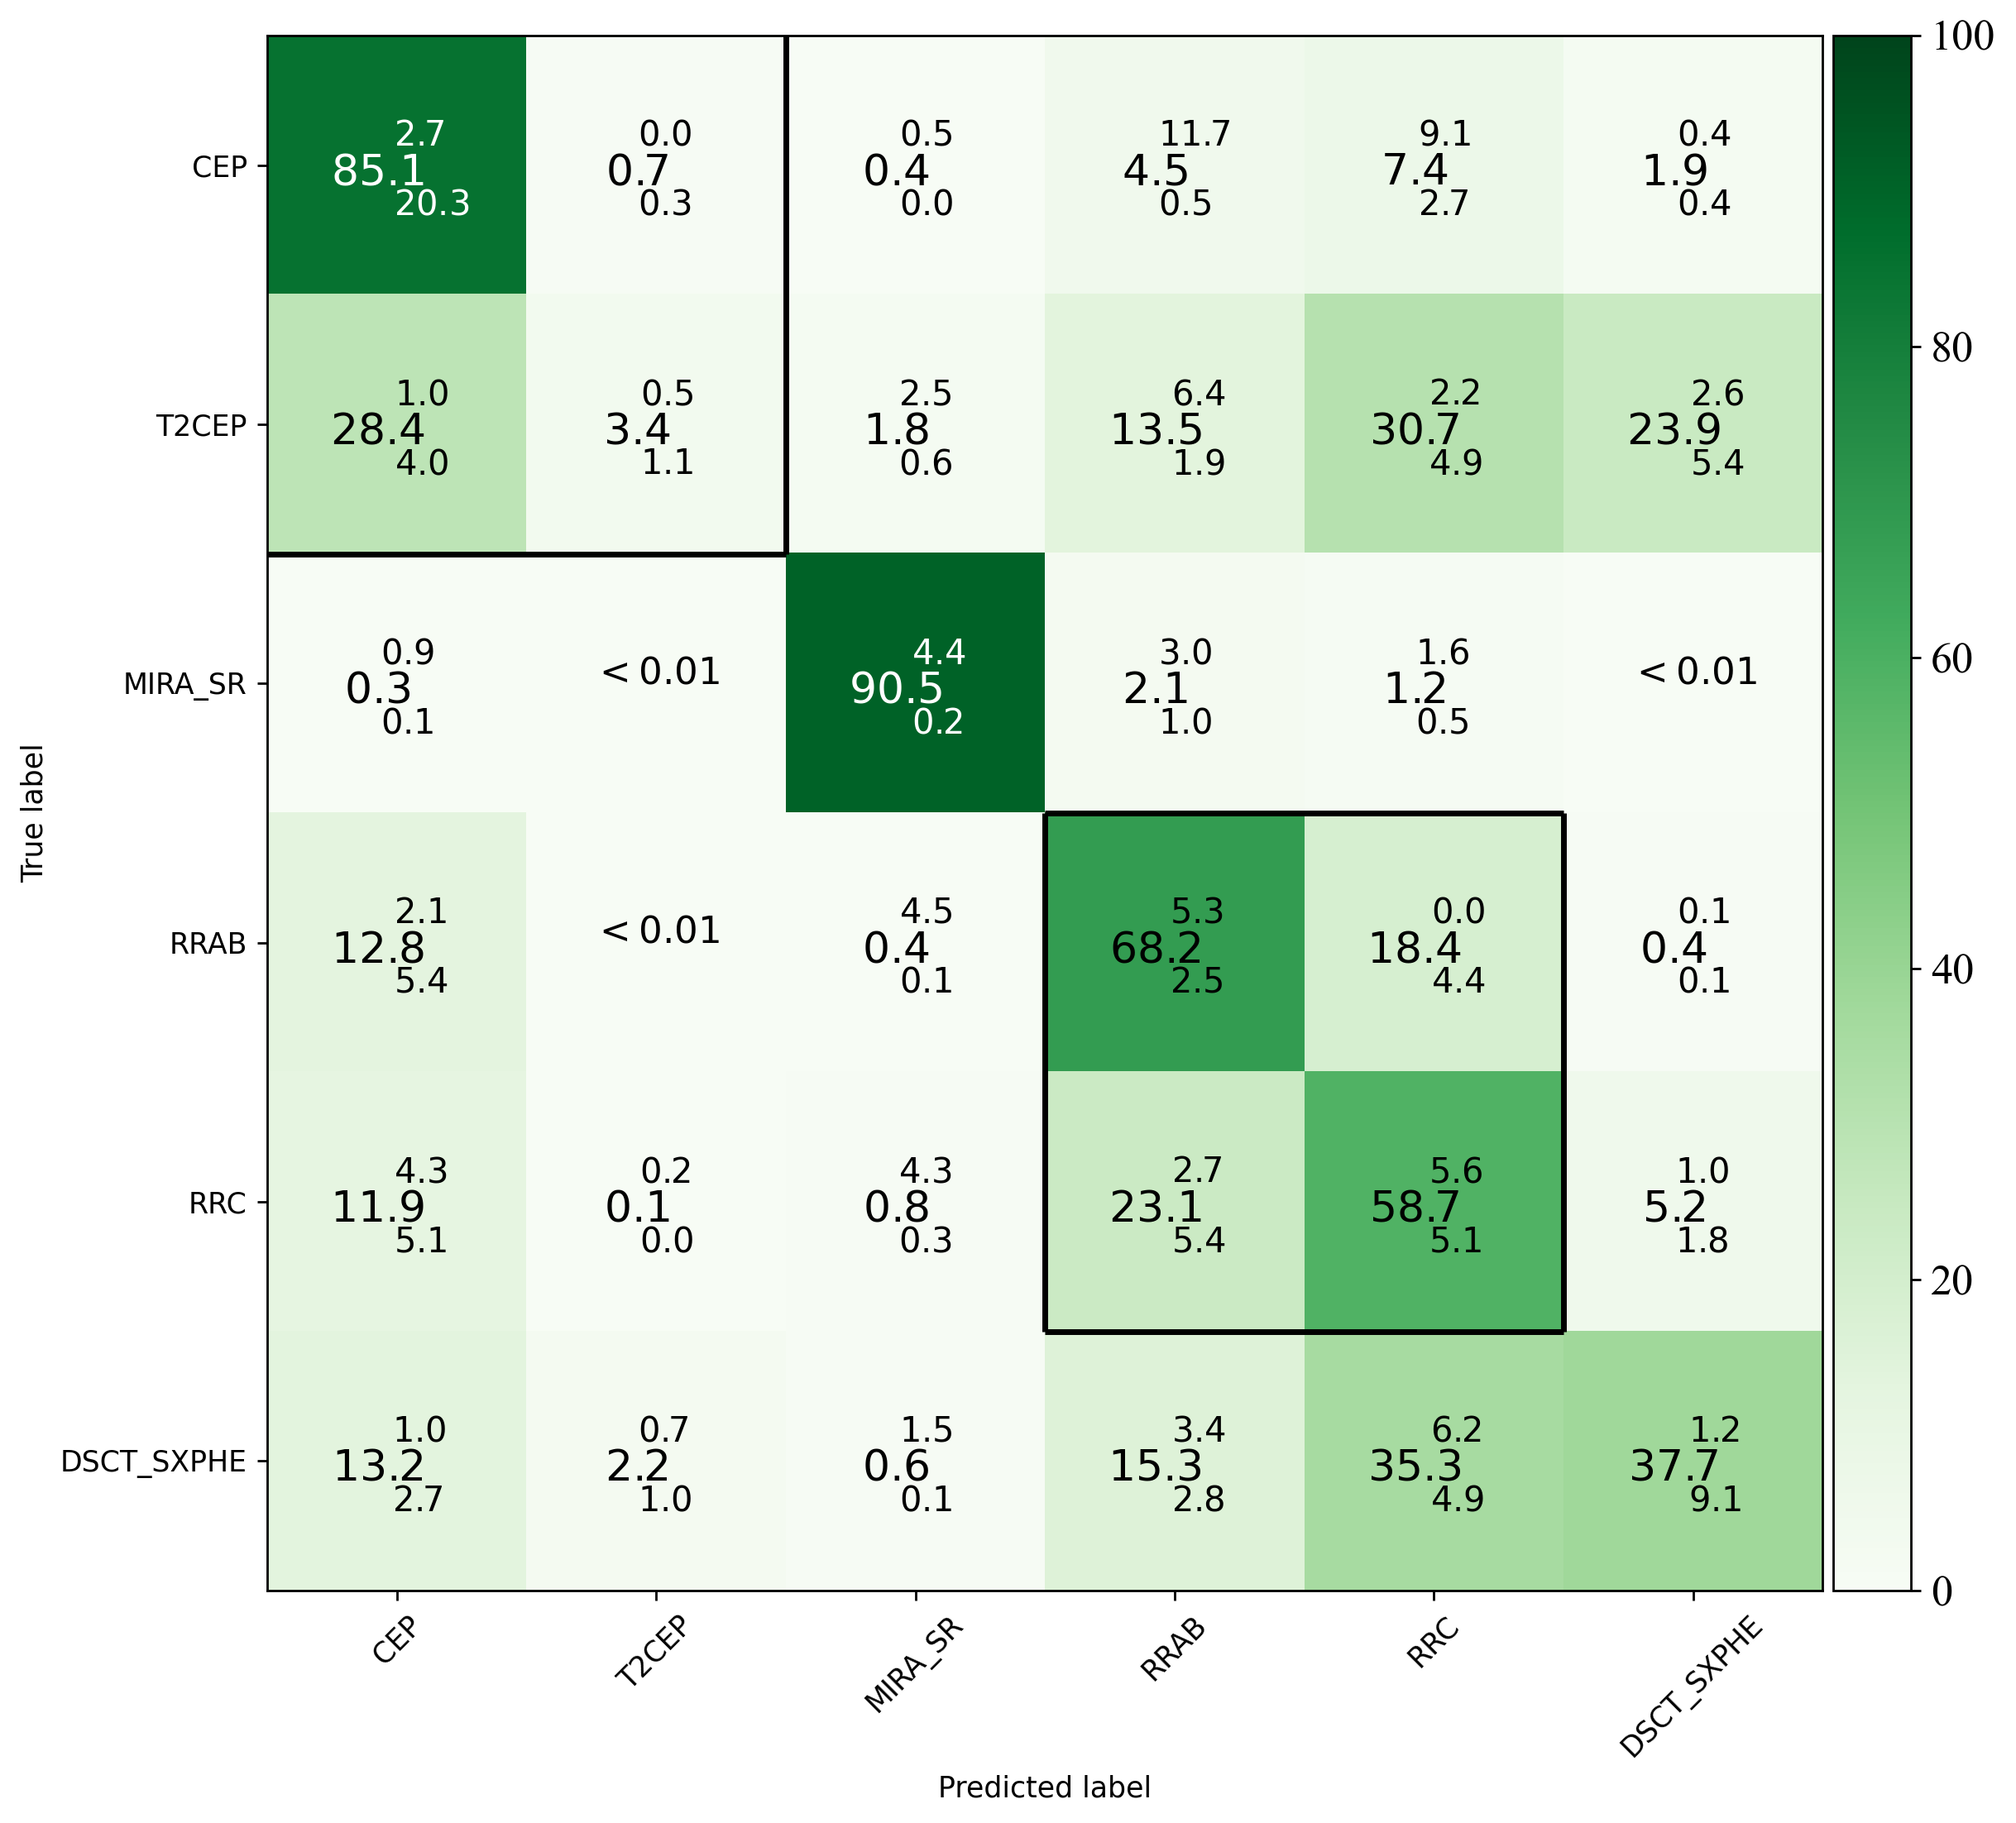

In [13]:
statistic='median'
img_path = './'+survey+'_'+statistic+'_c+r.pdf'
plot.plot_confusion_matrix(cm_folds, labels_=label_order, survey=survey, statistic=statistic, save_path=img_path)

In [14]:
accuracies = [reports_folds[i]['accuracy'] for i in range(len(reports_folds))]
np.round(np.median(accuracies),4), np.round(np.mean(accuracies),4)


(0.6514, 0.6676)